In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

In [ ]:
sales_df = pd.read_csv("sales_data_sample.csv" ,encoding='unicode_escape')

In [ ]:
sales_df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,12/2/2004 0:00,Shipped,4,12,2004,Ships,54,S72_3212,Euro Shopping Channel,(91) 555 94 44,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small
2819,10373,29,100.00,1,3978.51,1/31/2005 0:00,Shipped,1,1,2005,Ships,54,S72_3212,"Oulu Toy Supplies, Inc.",981-443655,Torikatu 38,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium
2820,10386,43,100.00,4,5417.57,3/1/2005 0:00,Resolved,1,3,2005,Ships,54,S72_3212,Euro Shopping Channel,(91) 555 94 44,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
2821,10397,34,62.24,1,2116.16,3/28/2005 0:00,Shipped,1,3,2005,Ships,54,S72_3212,Alpha Cognac,61.77.6555,1 rue Alsace-Lorraine,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small


In [ ]:
sales_df.dtypes


ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [ ]:
sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])

In [ ]:
#convert order date into datetime 
sales_df.dtypes


ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

In [ ]:
# Check the number of non-null values in the dataframe
sales_df.info()

# Check the number of Null values in the data
sales_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [ ]:
# since there are lot of Null values in 'addressline2', 'state', 'postal code' and 'territory' we can drop them. 
# Country would represent the order grographical information.
# Also drop city, address1, phone number, contact_name, contact last_name and contact first_name since they are not required for the analysis

df_drop  = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop(df_drop, axis = 1)
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,USA,Medium


In [ ]:
sales_df.isnull().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

In [ ]:
sales_df.nunique()

QUANTITYORDERED      58
PRICEEACH          1016
ORDERLINENUMBER      18
SALES              2763
ORDERDATE           252
STATUS                6
QTR_ID                4
MONTH_ID             12
YEAR_ID               3
PRODUCTLINE           7
MSRP                 80
PRODUCTCODE         109
COUNTRY              19
DEALSIZE              3
dtype: int64

PERFORMING EXPLOROTORY ANALYSIS

In [ ]:
sales_df['COUNTRY'].value_counts().index

Index(['USA', 'Spain', 'France', 'Australia', 'UK', 'Italy', 'Finland',
       'Norway', 'Singapore', 'Canada', 'Denmark', 'Germany', 'Sweden',
       'Austria', 'Japan', 'Belgium', 'Switzerland', 'Philippines', 'Ireland'],
      dtype='object')

In [ ]:
#CHECKING THE NUMEBR OF SAMPLES BELONGING TO RESPECTIVE COUNTRY 
sales_df['COUNTRY'].value_counts()

USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: COUNTRY, dtype: int64

In [ ]:
#PLOTTLY IS USED AS IT GIVES A BETTER VISUALISATION 
def barplot_visualization(x): #BARPLOT IS A FUNCTION WHERE x IS ANY COLUMN WHOSE GRAPH NEEDS TO BE DEPECTED
  fig = plt.Figure(figsize = (12, 6))#SIZE OF THE GRAPH
  fig = px.bar(x = sales_df[x].value_counts().index, y = sales_df[x].value_counts(), color = sales_df[x].value_counts().index, height = 600) 
  fig.show()

In [ ]:
barplot_visualization('COUNTRY')

In [ ]:
barplot_visualization('MSRP')

In [ ]:
barplot_visualization('STATUS')

In [ ]:
#since the status column has unbalnced datatset we will drop the column from the memory 
sales_df.drop(columns= ['STATUS'], inplace = True)#inplace is a function that will remove the column from the memory 
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,USA,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Spain,Small
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Finland,Medium
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Spain,Medium
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,France,Small


In [ ]:
barplot_visualization('PRODUCTLINE')

In [ ]:
barplot_visualization('DEALSIZE')

In [ ]:
# we are getting the dummy variables cause it will be easier during computation
#this is done by first droping the column and then replacing the column with dummy variables
#so we are converting categorical variables and we adding dummy variables 

def dummies(x):
  dummy = pd.get_dummies(sales_df[x])
  sales_df.drop(columns = x , inplace = True)
  return pd.concat([sales_df, dummy], axis = 1)

In [ ]:
sales_df = dummies('PRODUCTLINE')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,USA,Small,0,1,0,0,0,0,0
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,France,Small,0,1,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,France,Medium,0,1,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,USA,Medium,0,1,0,0,0,0,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,USA,Medium,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,Spain,Small,0,0,0,1,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,Finland,Medium,0,0,0,1,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,Spain,Medium,0,0,0,1,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,France,Small,0,0,0,1,0,0,0


In [ ]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,USA,Small,0,1,0,0,0,0,0
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,France,Small,0,1,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,France,Medium,0,1,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,USA,Medium,0,1,0,0,0,0,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,USA,Medium,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,Spain,Small,0,0,0,1,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,Finland,Medium,0,0,0,1,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,Spain,Medium,0,0,0,1,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,France,Small,0,0,0,1,0,0,0


In [ ]:
sales_df = dummies('DEALSIZE')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,COUNTRY,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,USA,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,France,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,France,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,USA,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,USA,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,Spain,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,Finland,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,Spain,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,France,0,0,0,1,0,0,0,0,0,1


In [ ]:
sales_df = dummies('COUNTRY')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
y = pd.Categorical(sales_df['PRODUCTCODE'])
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962',
                           'S700_4002', 'S72_1253', 'S72_3212']

In [ ]:
#GETTING THE UNIGUE VALUES OF THE PRODUCT CODE 
y = pd.Categorical(sales_df['PRODUCTCODE']).codes
y

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

In [ ]:
#APPLYING ONE HOT ENCODER OF THE DATA SET 
sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes

In [ ]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,108,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,108,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,108,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,108,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Grouping data by order date
sales_df_group = sales_df.groupby(by = "ORDERDATE").sum()
sales_df_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
ORDERDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174.0,0,0,0,0,0,0,4,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181.0,0,0,0,0,0,0,4,0,2,2,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37.0,0,0,0,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723.0,3,0,0,0,0,7,6,0,10,6,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720.0,7,0,0,0,2,4,0,0,8,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101.0,0,6,0,0,0,0,0,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462.0,14,0,0,0,0,0,0,2,8,4,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797.0,7,0,0,0,0,0,8,0,8,7,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [ ]:
#knowing when the sales peak 
#knwoing which month 
fig = px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')
fig.show()

In [ ]:
#the column orderdate is dropeed as the day the order is placed in not that relevant 
sales_df.drop("ORDERDATE", axis = 1, inplace = True)
sales_df.shape

(2823, 38)

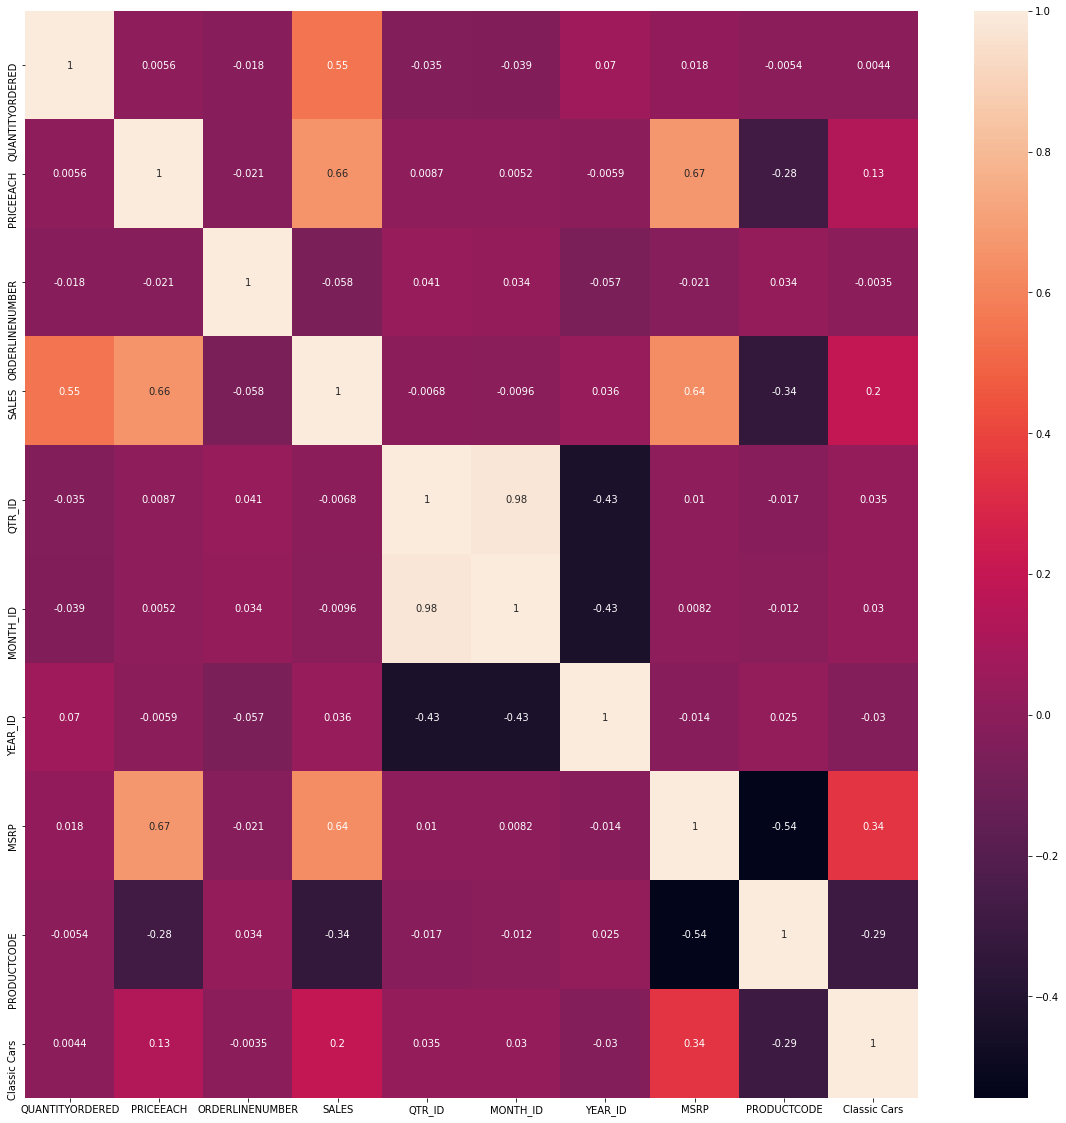

In [ ]:
#plotting a coorelation matrix 
#using only for 1st 6 columns 
plt.figure(figsize = (20, 20))#specifying the size of the matrix 
corr_matrix = sales_df.iloc[:, :10].corr()
sns.heatmap(corr_matrix, annot = True, cbar = True)

In [ ]:
#Since month_id and quater_id are equal to 1 we can delete either one of the columns 
sales_df.drop("QTR_ID", axis = 1, inplace = True)
sales_df.shape

(2823, 37)

In [ ]:
#plotting 3 different types of graphs 
# Histogram,KDE and RUG plot 
#used for creating 
#KDE plot- it is used to get the probability of a continuous variable 
#RUG plot - it is basically a plot of data for a single variable 
import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
  if sales_df.columns[i] != 'ORDERLINENUMBER':
    fig = ff.create_distplot([sales_df[sales_df.columns[i]].apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text = sales_df.columns[i])
    fig.show()

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()
#the pair plots show there is a relatioship between Sales and Quantity order 
#the pair plots show there is a relatioship between MSRP and PRICEEACH
#the pair plots also show the relatioship between PRICEEACH and Sales

<Figure size 1080x1080 with 0 Axes>

APPLYING ELBOW METHOD TO FIND THE OPTIMMAL NUMBER OF CLUSTERS 

In [ ]:
# Scale the data
#Basically we are normalizing the data 
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [ ]:
sales_df_scaled.shape

(2823, 37)

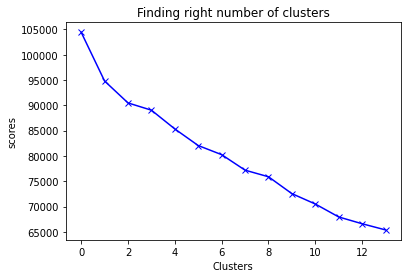

In [ ]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(sales_df_scaled)
  scores.append(kmeans.inertia_) # intertia is the Sum of squared distances of samples to their closest cluster center other way is known as WSCC(Within-Cluster-Sum-Squares)
#scores is the place where we are storing the WCCA values 
plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

APPLY K-MEANS ALGORITHM 

In [ ]:
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_

In [ ]:
labels

array([2, 2, 4, ..., 1, 1, 1], dtype=int32)

In [ ]:
kmeans.cluster_centers_.shape#shape of the centroid 

(5, 37)

In [ ]:
#centers of the data 
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers 

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,1.245428,0.800220,-0.259579,2.573861,-0.088008,0.136857,1.430265,-0.871802,0.580097,0.011712,-0.164278,-0.300637,-0.128350,-0.201008,-0.151285,4.120788,-0.980703,-0.912100,-0.084647,0.043374,-0.108756,-0.118498,0.107642,-0.004181,0.071653,0.023985,0.094193,0.023250,0.005118,0.010166,-0.029737,-0.015199,-0.039435,-0.052984,-0.105371,-0.116045,0.108611
1,-0.037064,0.022711,0.073632,-0.265903,-0.047668,-0.015074,-0.362613,1.121963,-0.721812,-0.364452,-0.348674,3.326275,-0.167454,-0.345470,-0.523371,-0.242672,-0.071440,0.183429,-0.228082,-0.009413,0.356424,-0.159458,0.279733,0.046856,-0.050171,-0.087824,-0.075499,-0.065071,0.032032,-0.176195,-0.096414,-0.059436,0.172005,0.179613,-0.105371,0.243326,-0.078269
2,-0.461342,-0.779231,0.043110,-0.826847,0.005076,-0.003544,-0.591039,0.177376,-0.091145,0.066183,0.108404,-0.300637,0.105159,-0.028944,0.153238,-0.242672,-0.980703,1.096370,0.061762,-0.025301,-0.026131,-0.159458,-0.042860,0.001522,0.024732,0.013757,0.019143,0.063102,0.041338,0.021288,0.005852,0.024175,-0.012009,-0.017271,-0.028675,-0.001763,-0.011988
3,-0.261002,0.060793,-0.127485,-0.237708,0.172917,0.160741,-0.080207,0.313283,-0.324801,-0.319404,0.117513,0.435258,-0.167454,0.405851,0.005773,-0.242672,-0.024000,0.135797,-0.264819,-0.140961,-0.108756,6.271250,-0.151083,-0.183541,-0.353765,-0.149852,-0.075499,-0.204199,-0.136988,-0.176195,-0.096414,-0.169676,-0.371278,-0.143553,-0.105371,-0.231843,-0.742934
4,0.279858,0.593595,-0.012142,0.481083,0.005322,-0.020200,0.420677,-0.264829,0.154088,0.020669,-0.022120,-0.300637,-0.039860,0.089648,-0.027219,-0.242672,1.019676,-0.912100,0.009749,0.026760,-0.019513,-0.159458,-0.015792,0.001038,-0.002918,0.008317,-0.011610,-0.037008,-0.035928,0.020266,0.020738,-0.000041,0.005988,-0.001474,0.063376,-0.013853,0.051901


In [ ]:
#unscaling the data by doing inverse transformation 
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers 
#the clusters change each time its runned 

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,6.178344e-01,1.210191e-01,5.732484e-02,-1.110223e-16,6.369427e-03,4.458599e-02,1.528662e-01,1.000000e+00,-7.771561e-16,9.992007e-16,4.458599e-02,2.547771e-02,-1.908196e-17,6.369427e-03,3.821656e-02,3.184713e-02,1.337580e-01,2.547771e-02,1.273885e-02,4.458599e-02,0.019108,3.184713e-02,6.369427e-03,2.547771e-02,1.082803e-01,0.012739,4.336809e-17,2.547771e-02,4.076433e-01
1,34.731818,84.116636,6.777273,3064.218727,6.918182,2003.804545,86.145455,89.204545,3.885781e-16,-3.747003e-16,5.551115e-17,1.000000e+00,-1.249001e-16,6.938894e-17,5.551115e-16,-1.873501e-16,4.545455e-01,5.454545e-01,9.090909e-03,1.818182e-02,5.000000e-02,6.245005e-17,6.363636e-02,4.090909e-02,9.545455e-02,9.090909e-03,-1.821460e-17,2.727273e-02,0.022727,1.075529e-16,2.949030e-17,1.818182e-02,1.772727e-01,0.045455,5.551115e-17,1.045455e-01,3.181818e-01
2,30.599467,67.940915,6.648313,2031.217931,7.111012,2003.812611,76.967140,59.374778,2.992895e-01,1.385435e-01,1.420959e-01,-4.579670e-16,4.440497e-02,9.769094e-02,2.779751e-01,5.412337e-16,-1.054712e-15,1.000000e+00,8.081705e-02,1.598579e-02,8.880995e-03,1.387779e-16,1.598579e-02,3.285968e-02,1.190053e-01,2.397869e-02,7.104796e-03,5.239787e-02,0.023979,3.374778e-02,9.769094e-03,3.197158e-02,1.172291e-01,0.017762,7.992895e-03,5.062167e-02,3.499112e-01
3,32.550725,84.884783,5.927536,3116.140145,7.724638,2003.927536,97.492754,63.666667,1.884058e-01,1.449275e-02,1.449275e-01,2.028986e-01,2.081668e-17,2.318841e-01,2.173913e-01,6.245005e-17,4.782609e-01,5.217391e-01,1.387779e-17,-3.469447e-18,8.673617e-18,1.000000e+00,1.387779e-17,2.775558e-17,8.326673e-17,4.163336e-17,3.469447e-18,-2.775558e-17,0.000000,4.510281e-17,-8.673617e-18,2.775558e-17,-9.714451e-17,0.000000,-3.469447e-18,4.857226e-17,-3.330669e-16
4,37.818545,95.631783,6.414868,4439.821271,7.111910,2003.800959,117.618705,45.410072,4.156675e-01,1.239009e-01,1.015188e-01,-1.013079e-15,2.078337e-02,1.342926e-01,2.038369e-01,-2.775558e-17,1.000000e+00,-7.827072e-15,6.794564e-02,2.318145e-02,9.592326e-03,1.422473e-16,1.998401e-02,3.277378e-02,1.103118e-01,2.318145e-02,4.796163e-03,3.277378e-02,0.013589,3.357314e-02,1.119105e-02,2.797762e-02,1.231015e-01,0.019984,1.758593e-02,4.796163e-02,3.804956e-01


In [ ]:
labels.shape

(2823,)

In [ ]:
labels.max()

4

In [ ]:
labels.min()

0

In [ ]:
y_kmeans = kmeans.fit_predict(sales_df_scaled)
y_kmeans


array([1, 1, 3, ..., 3, 1, 3], dtype=int32)

In [ ]:
y_kmeans.shape

(2823,)

In [ ]:
#concatenating the label to the data set 
sale_df_cluster = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
1,34,81.35,5,2765.90,5,2003,95,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2
2,41,94.74,2,3884.34,7,2003,95,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4
3,45,83.26,6,3746.70,8,2003,95,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
4,49,100.00,14,5205.27,10,2003,95,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2819,29,100.00,1,3978.51,1,2005,54,108,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2820,43,100.00,4,5417.57,3,2005,54,108,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2821,34,62.24,1,2116.16,3,2005,54,108,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x: float(x))

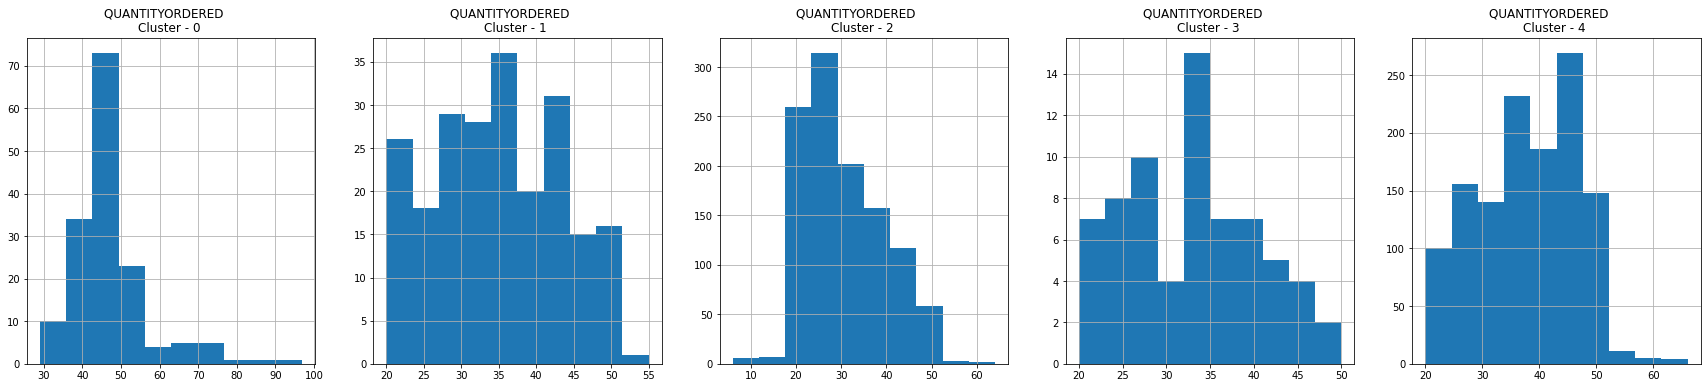

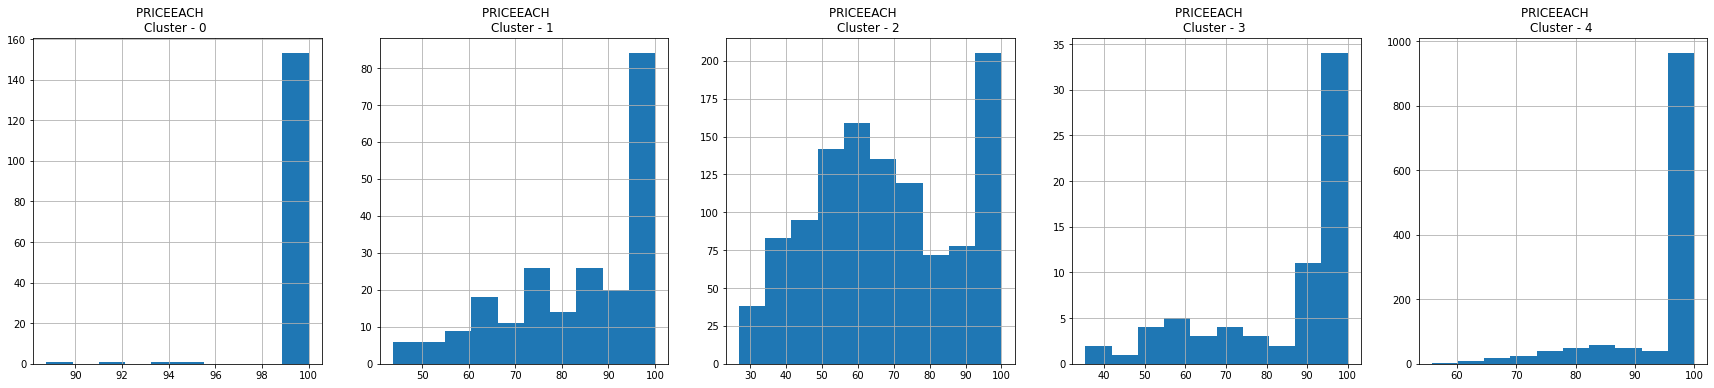

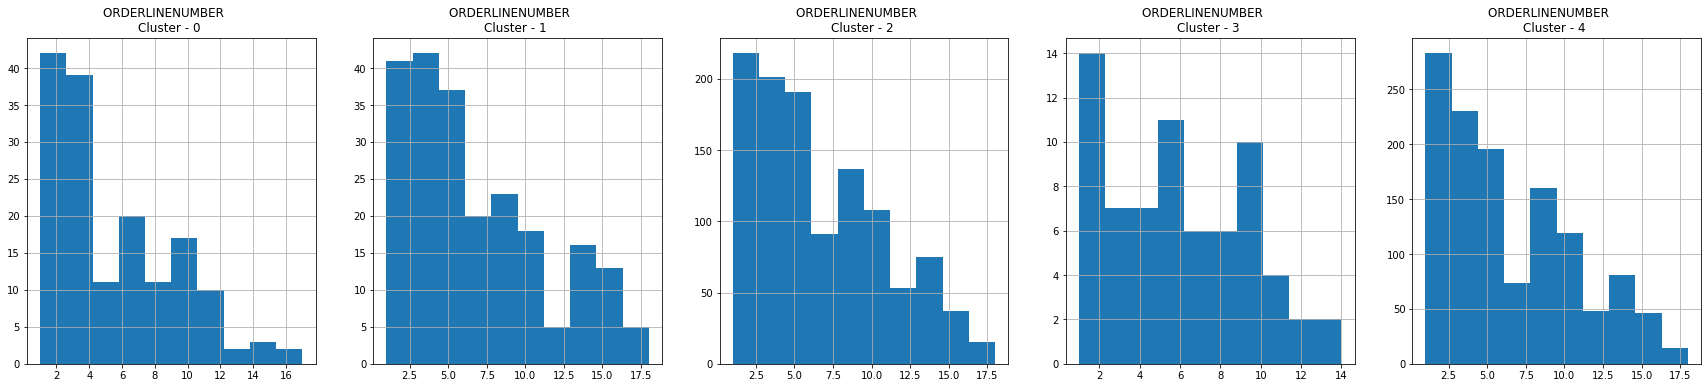

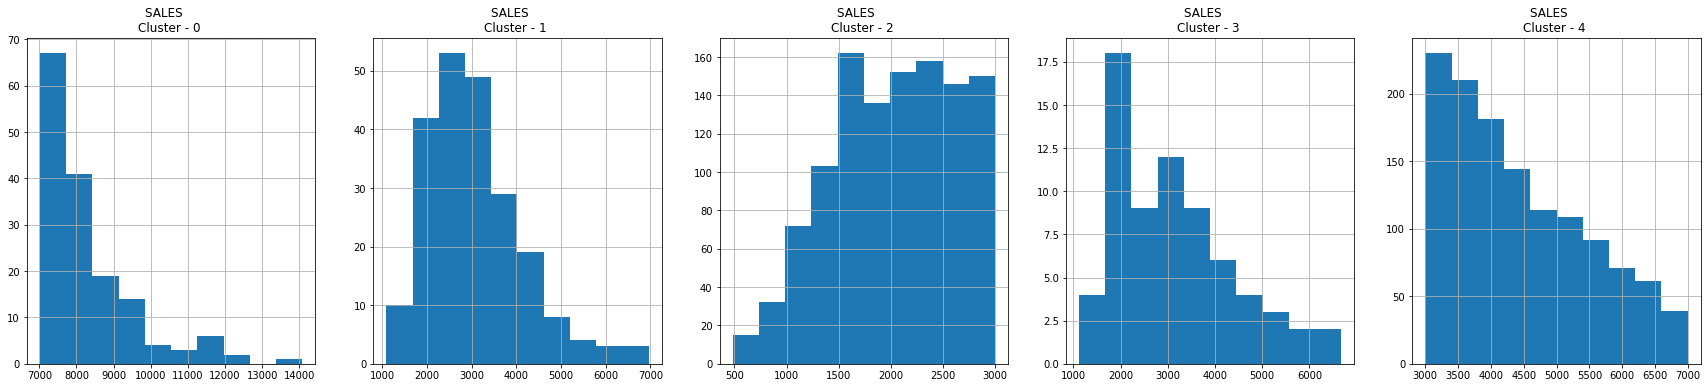

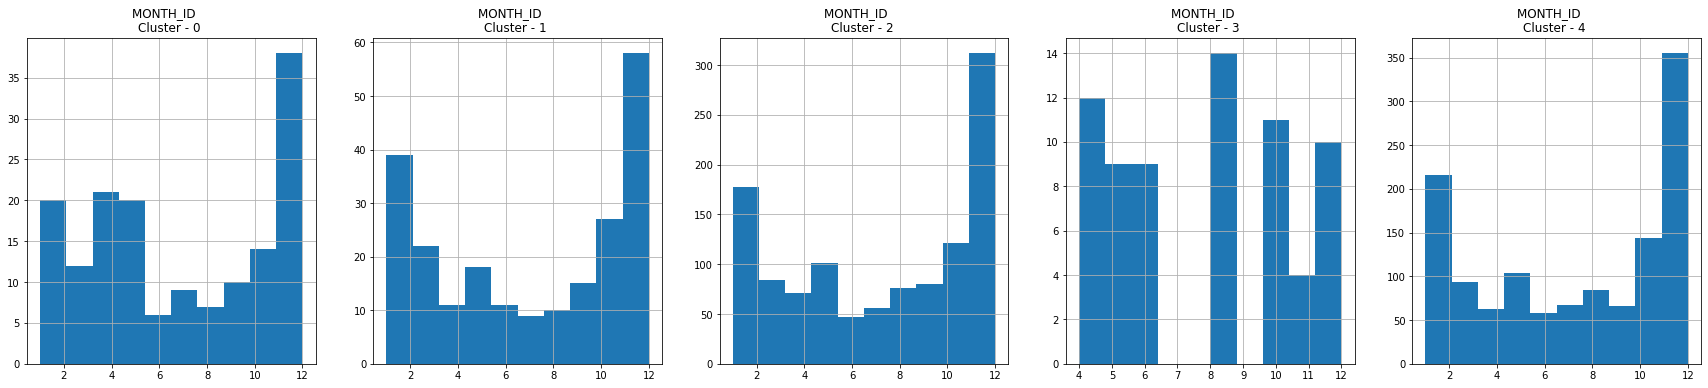

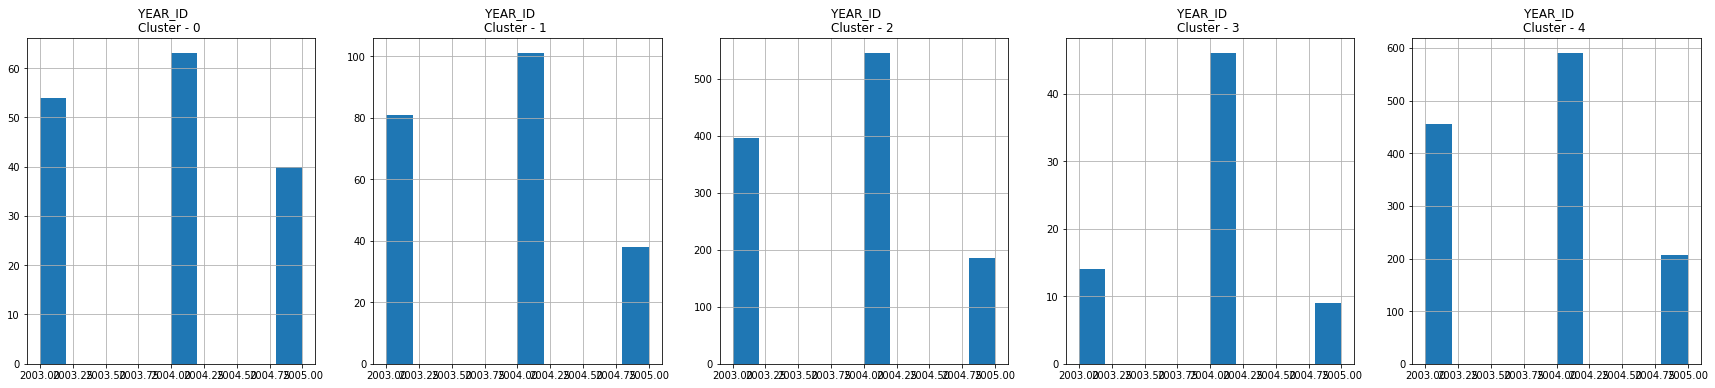

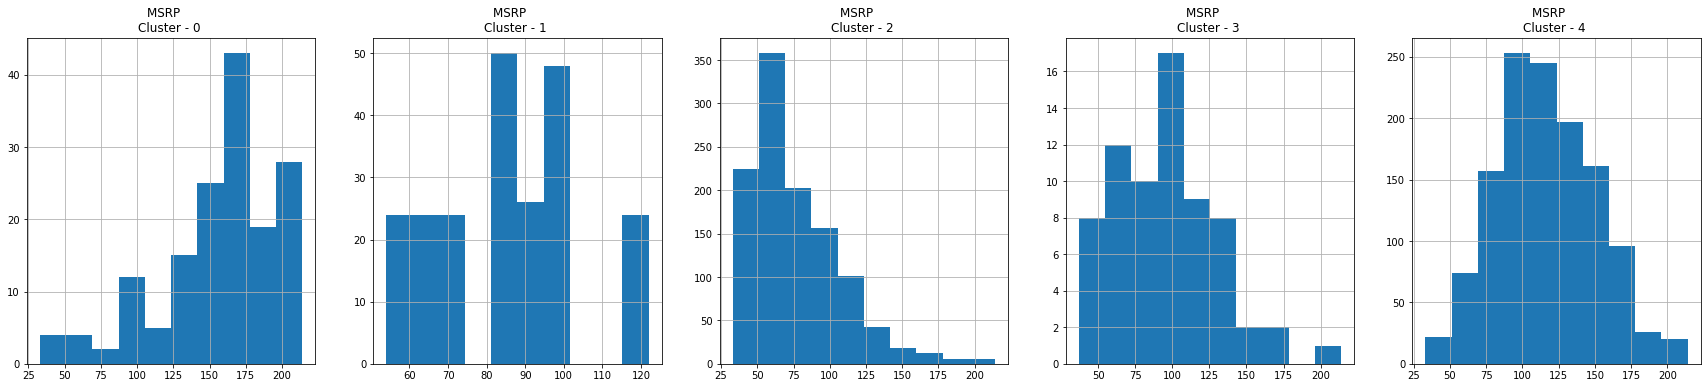

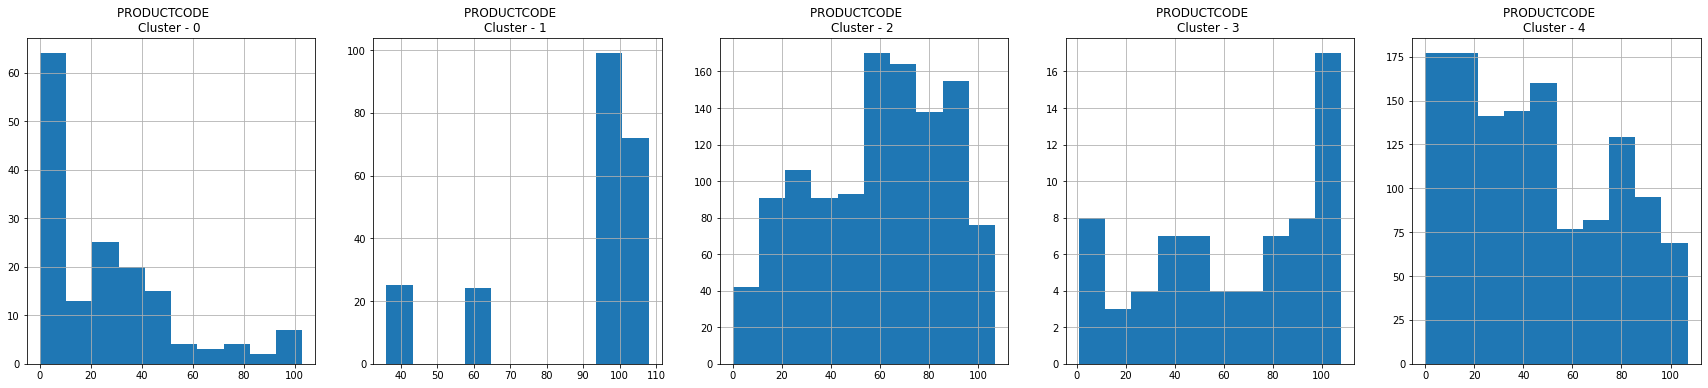

In [ ]:
#histogram for each and evry cluster 
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(5):
    plt.subplot(1, 5, j+1)
    cluster = sale_df_cluster[sale_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))
  
  plt.show()

In [ ]:
#PCA helps is reducing the features and even helps in keeping the information a secret 
pca = PCA(n_components = 3)#no of componenets 
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.48641186, -1.21779507,  0.91340497],
       [-0.78476155, -1.03965522,  1.33727706],
       [ 1.43143623,  0.11046519,  0.19649356],
       ...,
       [ 0.38999945,  4.08908174, -0.02864404],
       [-2.78892734,  2.39469789,  1.52878352],
       [-0.70541709,  3.3187276 , -0.46554525]])

In [ ]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2', 'pca3'])#different componenets 
pca_df.head()

,pca1,pca2,pca3
0,-0.486412,-1.217795,0.913405
1,-0.784762,-1.039655,1.337277
2,1.431436,0.110465,0.196494
3,1.288459,-0.239830,-0.628224
4,1.976023,-0.147323,-1.065344


In [ ]:
#concatinating the cluster and the pca data frame 
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

,pca1,pca2,pca3,cluster
0,-0.486412,-1.217795,0.913405,2
1,-0.784762,-1.039655,1.337277,2
2,1.431436,0.110465,0.196494,4
3,1.288459,-0.239830,-0.628224,4
4,1.976023,-0.147323,-1.065344,4
...,...,...,...,...
2818,-2.450362,1.110850,-1.460216,1
2819,-0.158198,3.734428,0.710329,1
2820,0.389999,4.089082,-0.028644,1
2821,-2.788927,2.394698,1.528784,1


In [ ]:
#plotting the different pca in 3D
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3', 
              color = 'cluster', symbol = 'cluster', size_max = 18, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

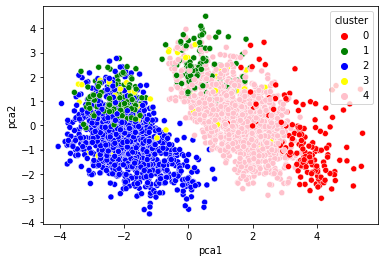

In [ ]:
#Visualisation using 2d
ax = sns.scatterplot(x = "pca1", y = 'pca2', hue = "cluster" , data = pca_df, palette = ['red' , 'green' , 'blue' ,'yellow' , 'pink'])

In [ ]:
sales_df.shape

(2823, 37)

USING AUTO ENCODERS 

In [ ]:
# from keras.optimizers import SGD

# AUTOENCODER IS MAINLY USED TO FIND THE OPTIMAL NUMBER OF CLUSTERS 

input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

# encoder - used for dimensionality reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [ ]:
autoencoder.fit(sales_df, sales_df, batch_size = 128, epochs = 500, verbose = 3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [72]:
pred = encoder.predict(sales_df_scaled)

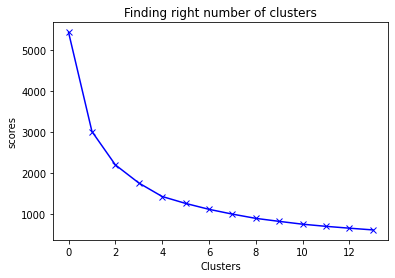

In [73]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

In [74]:
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)


In [75]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,cluster
0,30,95.70,2.0,2871.00,2,2003,95,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,34,81.35,5.0,2765.90,5,2003,95,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,41,94.74,2.0,3884.34,7,2003,95,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,45,83.26,6.0,3746.70,8,2003,95,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,49,100.00,14.0,5205.27,10,2003,95,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [76]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers 


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,0.293073,0.580208,-0.010805,0.458608,0.003368,-0.012482,0.376634,-0.165542,0.085141,-0.014094,-0.048853,-0.020232,-0.052121,0.064221,-0.064346,-0.242672,1.019676,-0.91210,-0.013717,0.010642,-0.007922,-0.006125,0.000556,0.003647,-0.011355,-0.001952,-0.017750,-0.042017,-0.024145,0.001387,0.009480,-0.003200,0.007377,0.015695,0.047160,0.001323,0.019290
1,-0.468912,-0.724370,0.043454,-0.810304,0.007142,-0.003285,-0.581757,0.285478,-0.162957,0.013781,0.072858,0.058660,0.071986,-0.044714,0.087993,-0.242672,-0.980703,1.09637,0.025174,-0.016801,0.021872,0.021124,-0.013783,-0.003425,0.003484,-0.000830,0.007626,0.042513,0.025440,-0.002742,-0.006592,0.005316,-0.003135,-0.010455,-0.038008,0.012783,-0.034126
2,1.245428,0.800220,-0.259579,2.573861,-0.088008,0.136857,1.430265,-0.871802,0.580097,0.011712,-0.164278,-0.300637,-0.128350,-0.201008,-0.151285,4.120788,-0.980703,-0.91210,-0.084647,0.043374,-0.108756,-0.118498,0.107642,-0.004181,0.071653,0.023985,0.094193,0.023250,0.005118,0.010166,-0.029737,-0.015199,-0.039435,-0.052984,-0.105371,-0.116045,0.108611


In [77]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,37.947254,95.361741,6.420520,4398.433699,7.104769,2003.806358,115.848988,48.545520,0.382948,0.112717,0.093208,7.731214e-02,0.018786,0.126445,0.188584,-5.273559e-16,1.000000e+00,-8.715251e-15,0.062139,0.020954,1.083815e-02,0.023844,0.022399,0.033237,0.107659,0.021676,0.004335,0.031792,0.015173,0.030347,0.010116,0.027457,0.123555,0.022399,1.589595e-02,0.051301,0.364884
1,30.525741,69.047496,6.649766,2061.682800,7.118565,2003.812793,77.340094,62.788612,0.265211,0.121685,0.131045,9.906396e-02,0.039002,0.092824,0.251170,-1.595946e-16,-1.054712e-15,1.000000e+00,0.071763,0.017161,1.404056e-02,0.028081,0.020281,0.031981,0.112324,0.021841,0.006240,0.048362,0.021841,0.029641,0.008580,0.028861,0.120125,0.018721,7.020281e-03,0.053822,0.339314
2,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,0.617834,0.121019,0.057325,-1.110223e-16,0.006369,0.044586,0.152866,1.000000e+00,-7.771561e-16,9.992007e-16,0.044586,0.025478,-1.908196e-17,0.006369,0.038217,0.031847,0.133758,0.025478,0.012739,0.044586,0.019108,0.031847,0.006369,0.025478,0.108280,0.012739,4.336809e-17,0.025478,0.407643


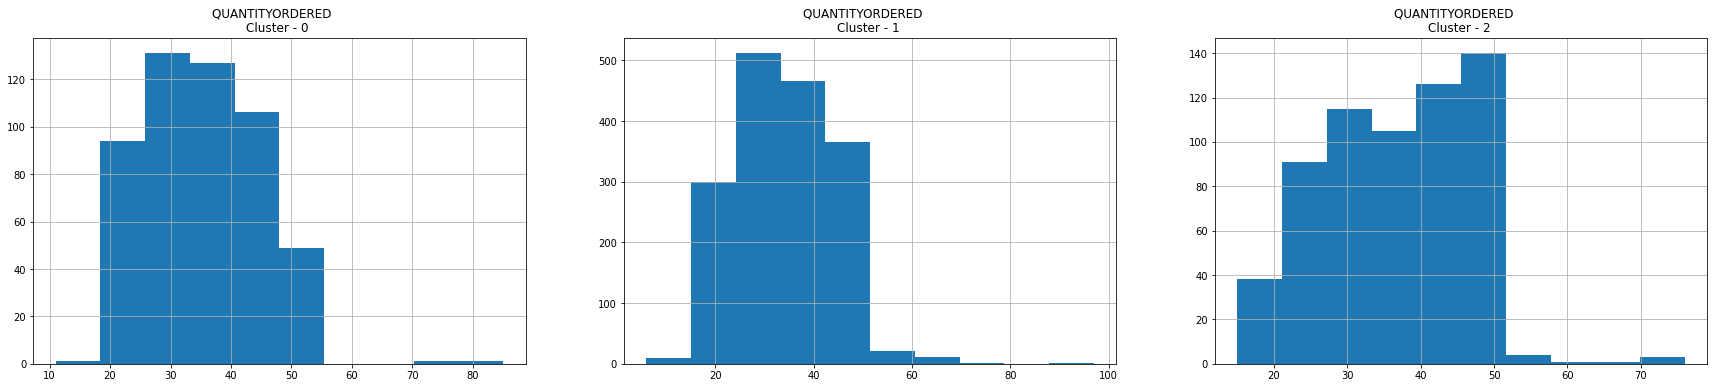

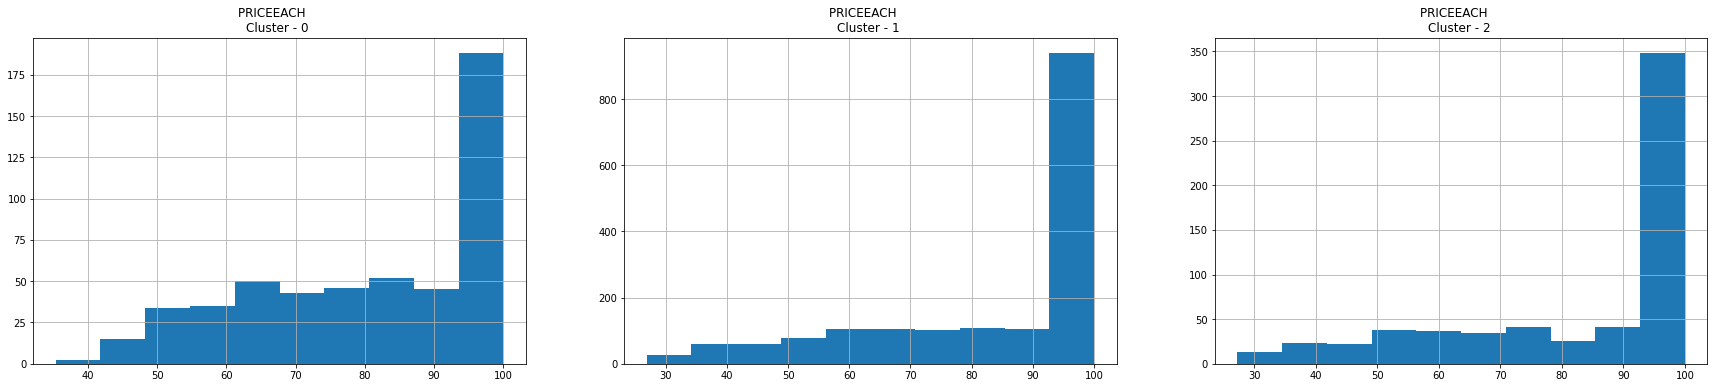

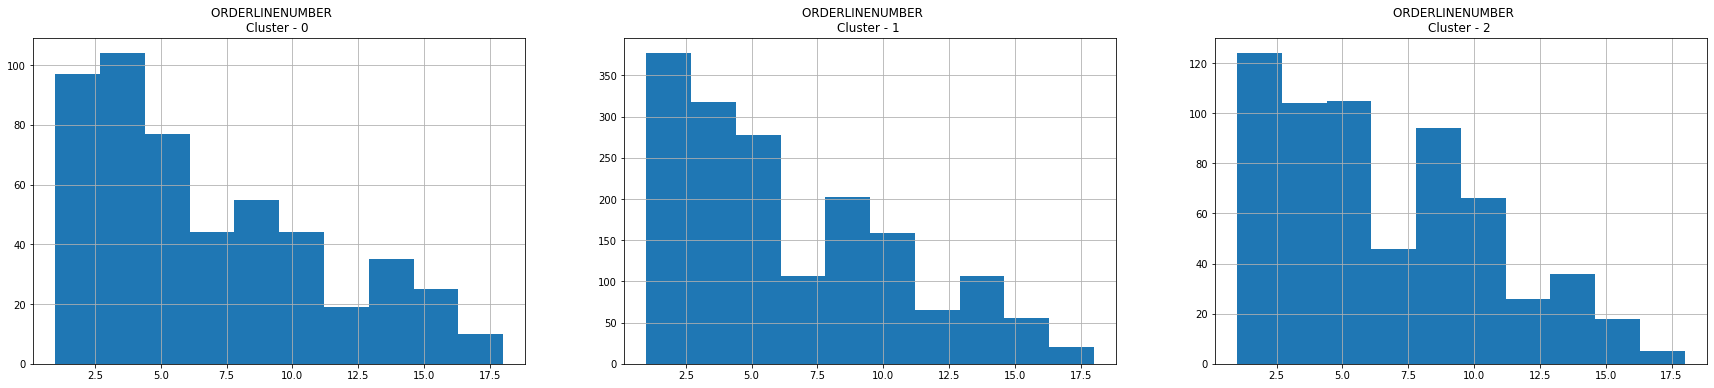

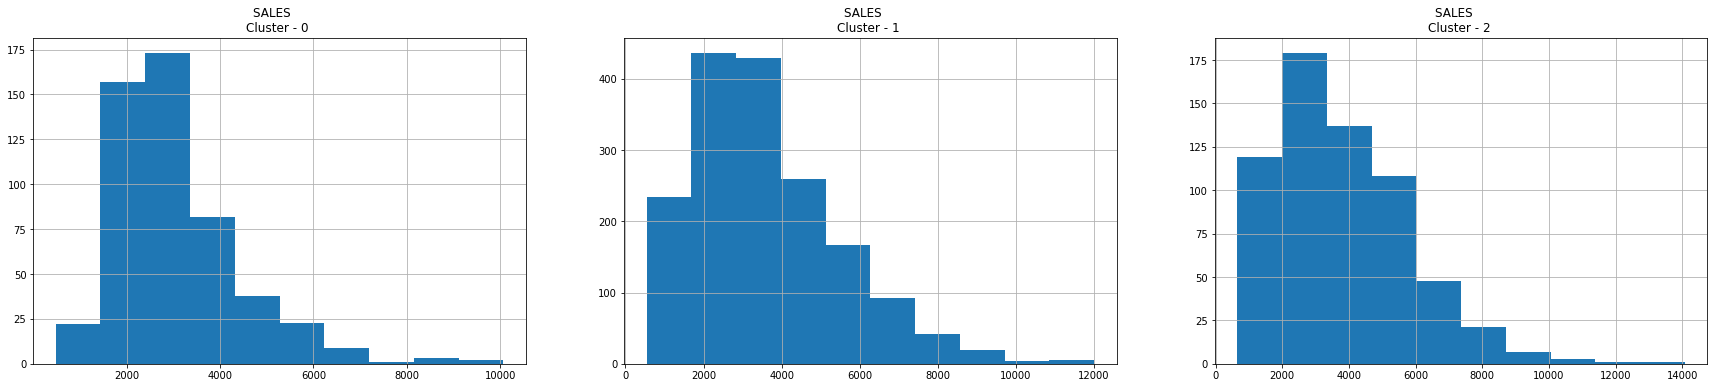

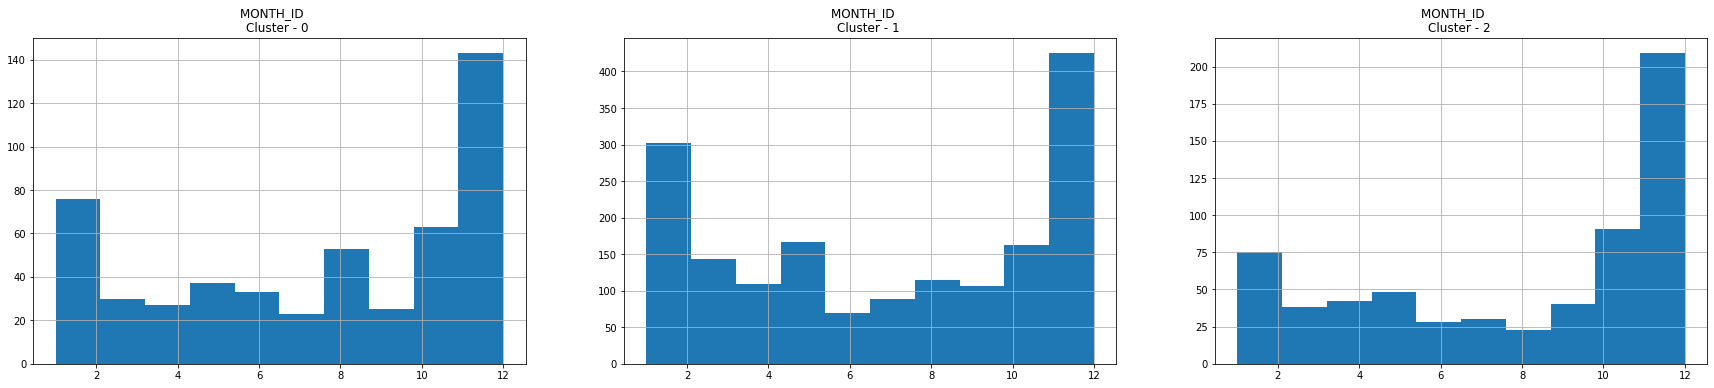

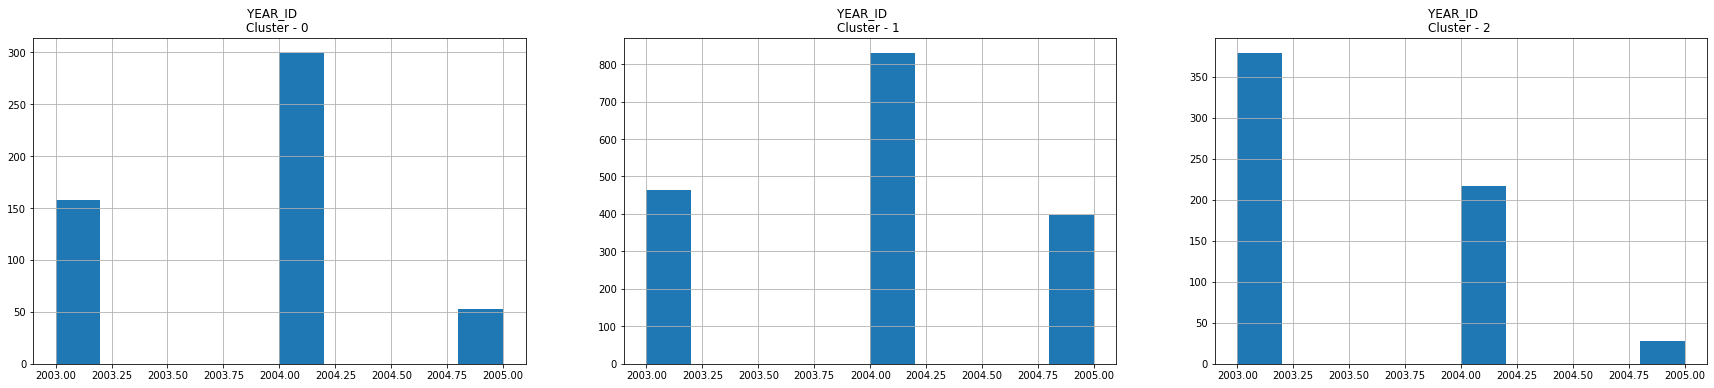

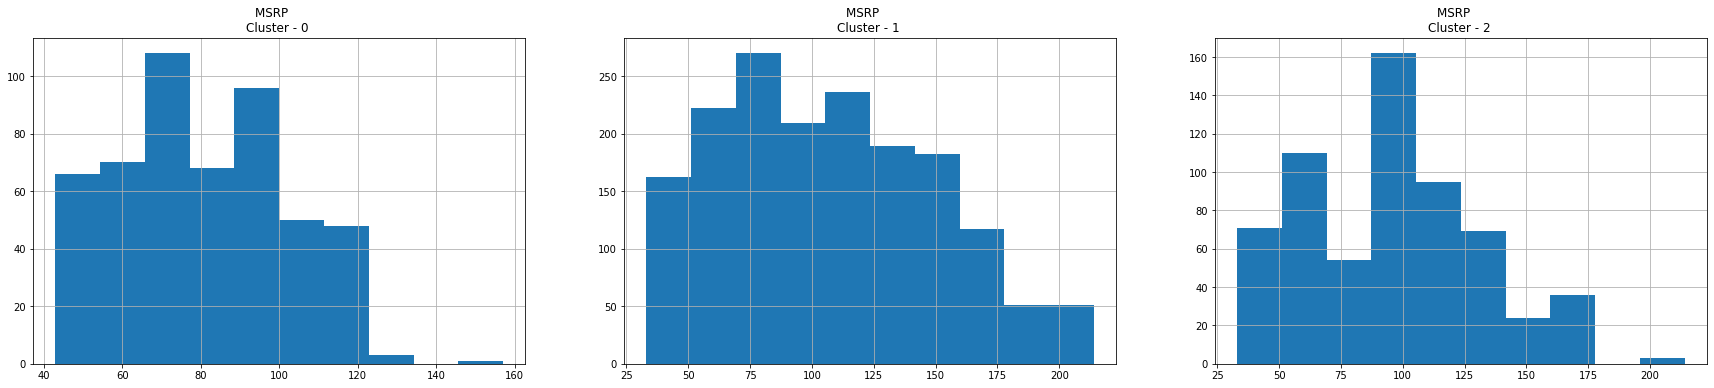

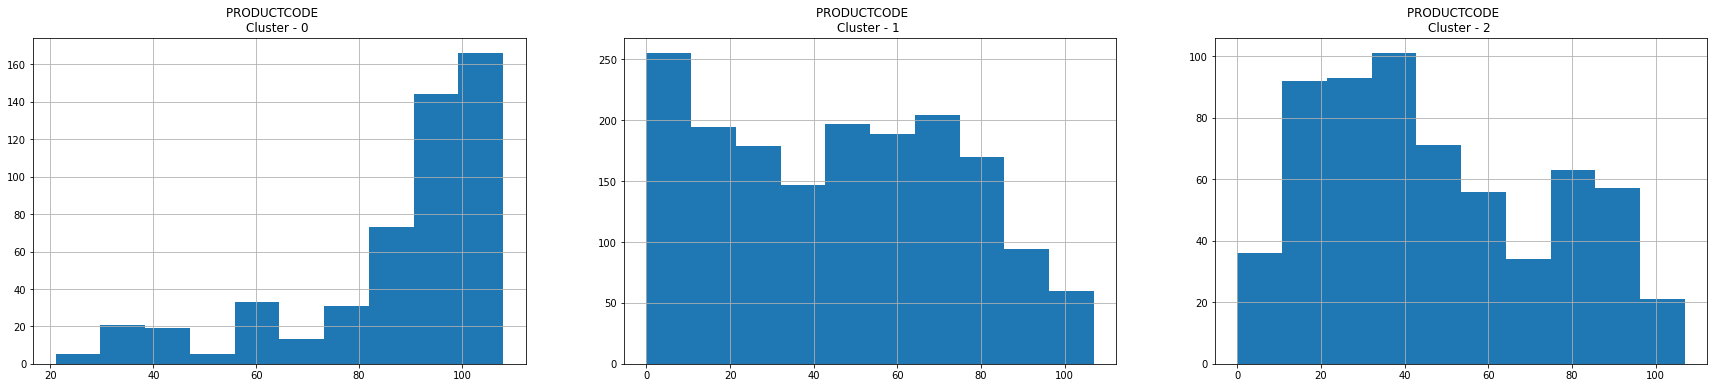

In [78]:
# plot histogram for each feature based on cluster 
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(3):
    plt.subplot(1, 3, j+1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))
  
  plt.show()


In [79]:
# Cluster 0 - This group represents customers who buy items in high quantity(47), they usually buy items with high prices(99). They bring-in more sales than other clusters. They are mostly active through out the year. They usually buy products corresponding to product code 10-90. They buy products with high mrsp(158).
# Cluster 1 - This group represents customers who buy items in average quantity(37) and they buy tend to buy high price items(95). They bring-in average sales(4398) and they are active all around the year.They are the highest buyers of products corresponding to product code 0-10 and 90-100.Also they prefer to buy products with high MSRP(115) .
# Cluster 2 - This group represents customers who buy items in small quantity(30), they tend to buy low price items(69). They correspond to the lowest total sale(2061) and they are active all around the year.They are the highest buyers of products corresponding to product code 0-20 and 100-110  they then to buy products with low MSRP(77).

In [80]:
# Reduce the original data to 3 dimension using PCA for visualize the clusters
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486321,-1.190320,0.947468
1,-0.784693,-1.024522,1.398228
2,1.431436,0.122854,0.284565
3,1.288391,-0.194402,-0.607580
4,1.975957,-0.085238,-1.091262


In [81]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-0.486321,-1.190320,0.947468,1
1,-0.784693,-1.024522,1.398228,1
2,1.431436,0.122854,0.284565,1
3,1.288391,-0.194402,-0.607580,1
4,1.975957,-0.085238,-1.091262,1


In [82]:
# Visualize clusters using 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 10, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))